In [15]:
import argparse
import pathlib
import random
from collections import deque
from typing import List, Dict, Tuple, Union
from data import Dataset
from data_utils import *
from models import BetaBernoulli
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sampling import *
%matplotlib inline  

import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
LINEWIDTH = 13.97

In [270]:
DATASET_LIST = ['svhn']
metric = 'difference' # 'ece', 'confusion_matrix'
group_method = 'predicted_class'
rope_width=0.03

In [271]:
def rope(ax, alpha0, alpha1, beta0, beta1, rope_width=0.01):
    num_samples = 10000
    theta_0 = np.random.beta(alpha0, beta0, size=(num_samples))
    theta_1 = np.random.beta(alpha1, beta1, size=(num_samples))
    delta = theta_0 - theta_1
    vals = ((delta < -rope_width).mean(), (np.abs(delta) <= rope_width).mean(), (delta > rope_width).mean())
    ax.hist(delta, bins=100, color = 'b', label='Bayesian', alpha=0.5)
    ax.axvline(x=-rope_width, label='rope', color='gold', linewidth = 4)
    ax.axvline(x=rope_width, color='gold', linewidth = 4)
    
    frequentist = (alpha0) / (alpha0+beta0) - (alpha1) / (alpha1+beta1)
    budget = alpha0 + alpha1 + beta0 + beta1
    ax.axvline(x=frequentist, color='red', linewidth = 3, label='Frequentist', linestyle='--')
    #ax.set_xlim(-0.05, 0.05)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks([])
    ax.annotate('$P(\Delta\ll0)=${:.2f}\n$P(\Delta\\approx 0)=${:.2f}\n$P(\Delta\gg0)=${:.2f}\n\n$N_1+N_2=${:.0f}'.\
                format(vals[0], vals[1], vals[2], budget[0]), xy=(0.12, 1.01), xycoords='axes fraction', \
                fontsize=11, ha='left', va='top')
    #print(frequentist)
    #ax.annotate('$Freq=${:.3f}'.format(frequentist[0]), \
     #           xy=(0.7,1.0), xycoords='axes fraction', fontsize=11, ha='left', va='top')
    print(vals)
    return ax

No handles with labels found to put in legend.


3593
(0.0, 0.9955, 0.0045)
187
(0.8849, 0.0941, 0.021)


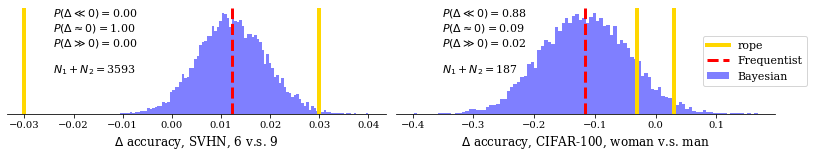

In [278]:
experiment_configs = [
    ('svhn', 6, 9, '6', '9'),
    #('svhn', 6, 1)
    #('cifar100', 27, 29, 'crocodile', 'dinosaur')
    ('cifar100', 98, 46, 'woman', 'man')
]
fig, axes = plt.subplots(ncols=len(experiment_configs), nrows=1, figsize=(LINEWIDTH*0.81,2.3))

for i, config in enumerate(experiment_configs):
    dataset_name, group0, group1, group0_name, group1_name = config    
    dataset = Dataset.load_from_text(dataset_name)
    dataset.group(group_method = group_method)
    
    deques = dataset.enqueue()
    budget = len(deques[group0]) + len(deques[group1]) 
    print(budget)
    dataset_len = dataset.__len__()
    dataset_accuracy_k = dataset.accuracy_k
    dataset_weight_k = dataset.weight_k
    
    del dataset, deques
    alpha0 = dataset_len * dataset_weight_k[group0] * (dataset_accuracy_k[group0]+ 1e-6)
    alpha1 = dataset_len * dataset_weight_k[group1] * (dataset_accuracy_k[group1]+ 1e-6), 
    beta0 = dataset_len * dataset_weight_k[group0] * (1-dataset_accuracy_k[group0] + 1e-6),
    beta1 = dataset_len * dataset_weight_k[group1] * (1-dataset_accuracy_k[group1] + 1e-6)
    axes[i] = rope(axes[i], alpha0, alpha1, beta0, beta1, rope_width)
    axes[1].legend(loc='center right', fontsize=11, bbox_to_anchor=(1.1, 0.5))
    axes[i].set_xlabel(r"$\Delta$ accuracy, %s, %s v.s. %s" % (DATASET_NAMES[dataset_name], group0_name, group1_name), fontsize=12)
plt.tight_layout()

In [277]:
CIFAR100_CLASSES = [
    "apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle",
    "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle",
    "caterpillar", "cattle", "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch",
    "crab", "crocodile", "cup", "dinosaur", "dolphin", "elephant", "flatfish", "forest", "fox",
    "girl", "hamster", "house", "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion",
    "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain", "mouse", "mushroom",
    "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree",
    "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road",
    "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake",
    "spider", "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone",
    "television", "tiger", "tractor", "train", "trout", "tulip", "turtle", "wardrobe", "whale",
    "willow_tree", "wolf", "woman", "worm"
]
CIFAR100_CLASSES.index('man')

46

In [275]:
fig.savefig('../figures/rope.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [5]:
dataset_accuracy_k
min_config = (0,1)
min_val = abs(dataset_accuracy_k[0] - dataset_accuracy_k[1])
for i in range(10):
    for j in range(i+1, 10):
        tmp = abs(dataset_accuracy_k[i] - dataset_accuracy_k[j])
        if tmp > min_val:
            min_val = tmp
            min_config = (i, j)
print(min_config)            

(2, 9)
